# Creating FAO Agro Maps per crop

This notebook uses input data from <a href="http://www.fao.org/land-water/land/land-governance/land-resources-planning-toolbox/category/details/en/c/1026341/">FAO Agro Maps</a>. The scope is to extract all crops available at the desired resolution (admin level 2) merge with spatial admin layer and produce output that can later on be used in the downscaling process.

**Original code:** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Conceptualization & Methodological review :** [Alexandros Korkovelos](https://github.com/akorkovelos) <br />
**Updates, Modifications:** [Alexandros Korkovelos](https://github.com/akorkovelos)<br />
**Funding:** The World Bank (contract number: 7190531), [KTH](https://www.kth.se/en/itm/inst/energiteknik/forskning/desa/welcome-to-the-unit-of-energy-systems-analysis-kth-desa-1.197296)

# PART 1: Preparing crop dataframes from FAO DATA

In [27]:
# Import necessary modules and libraries

# Part 1
import pandas as pd
import os

# Part 2
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
from shapely.geometry import Point, Polygon
%matplotlib inline

## Part 1. Creating csv files per crop

In [28]:
# Import agricultural data from FAO (http://kids.fao.org/agromaps/)
# STEP1: read in csv file version 

path = r"C:\Oluchi\Benin\ben_FAO_DATA"
name_of_file = "ben_all_data.csv"

In [29]:
# Import csv as pandas dataframe
df = pd.read_csv(path + "\\" + name_of_file)
df = df.drop(["CONTINENT_CODE", "CONTINENT_NAME"], axis=1)

In [30]:
df.head()

,COUNTRY_CODE,COUNTRY_NAME,AREA_CODE,AREA_NAME,ADMIN_LEVEL,ITEM_CODE,ITEM_NAME,YEAR,AEREA_HARVESTED,YIELD,PRODUCTION
0,BEN,Benin,BEN012001,Abomey,2,116,Potatoes,2001,NaN,NaN,NaN
1,BEN,Benin,BEN012001,Abomey,2,116,Potatoes,2002,NaN,NaN,NaN
2,BEN,Benin,BEN012001,Abomey,2,116,Potatoes,2003,NaN,NaN,NaN
3,BEN,Benin,BEN012001,Abomey,2,116,Potatoes,2004,NaN,NaN,NaN
4,BEN,Benin,BEN012001,Abomey,2,116,Potatoes,2005,NaN,NaN,NaN


In [31]:
print ("The number of administrative areas (level 2) is {}, as shown below:".format(df.AREA_NAME.nunique()))
df.AREA_NAME.unique()

The number of administrative areas (level 2) is 73, as shown below:


array(['Abomey', 'Abomey-Calavi', 'Adjara', 'Adjohoun', 'Agbangnizoun',
       'Aguegue', 'Akpro-misserete', 'Allada', 'Aplahoue', 'Athieme',
       'Avrankou', 'Banikoara', 'Bante', 'Bembereke', 'Bohicon', 'Bonou',
       'Bopa', 'Boukoumbe', 'Cobly', 'Come', 'Copargo', 'Cotonou', 'Cove',
       'Dangbo', 'Dassa', 'Djakotome', 'Djidja', 'Dogbo', 'Glazoue',
       'Gogounou', 'Grand-Popo', 'Houeyogbe', 'Ifangni', 'Adja-ouere',
       'Kalale', 'Kandi', 'Karimama', 'Kerou', 'Ketou', 'Klouekanme',
       'Kouande', 'Kpomasse', 'Lalo', 'Malanville', 'Materi',
       'Natitingou', "N'Dali", 'Nikki', 'Ouake', 'Ouesse', 'Ouidah',
       'Ouinhi', 'Parakou', 'Pehonko', 'Perere', 'Pobe', 'Porto-Novo',
       'Sakete', 'Savalou', 'Save', 'Segbana', 'Seme-Kpodji', 'Sinende',
       'So-ava', 'Tanguieta', 'Toucountouna', 'Toffo', 'Tori-bossito',
       'Toviklin', 'Za-kpota', 'Zangnanado', 'Ze', 'Zogbodome'],
      dtype=object)

<div class="alert alert-block alert-warning">
<b>Note_1:</b> According to the <a href="http://www.fao.org/land-water/land/land-governance/land-resources-planning-toolbox/category/details/en/c/1026341/">data source</a> the most recent year for which admin level 2 data for harvested area are availavle, is the year 2000. 
</div>

In [32]:
print ("The number of crops is {}, as shown below:".format(df.ITEM_NAME.nunique()))
df.ITEM_NAME.unique()

The number of crops is 27, as shown below:


array(['Potatoes', 'Sweet Potatoes', 'Cassava', 'Taro (Coco Yam)', 'Yams',
       'Sugar Cane', 'Broad Beans, Dry', 'Cow Peas, Dry', 'Pigeon Peas',
       'Bambara Beans', 'Soybeans', 'Groundnuts in Shell', 'Rice, Paddy',
       'Sesame Seed', 'Seed Cotton', 'Tomatoes',
       'Chillies&Peppers, Green', 'Onions, Dry', 'Okra', 'Maize',
       'Watermelons', 'Pineapples', 'Pimento, Allspice', 'Millet',
       'Tobacco Leaves', 'Sorghum', 'Fonio'], dtype=object)

<div class="alert alert-block alert-warning">
<b>Note_2:</b> According to the <a href="http://www.fao.org/land-water/land/land-governance/land-resources-planning-toolbox/category/details/en/c/1026341/">data source</a> the crops for which admin level 2 data for harvested area are availavle include Maize, Cassava, Dry Beans and Rice Paddy. Therefore we only focus on these crops.
</div>

### Extracting crop data per admin 2 to unique datarames

#### Maize

In [33]:
# Select crop and data as per availability
df_maize_2000_admin2 = df[(df['AEREA_HARVESTED'].notnull()) & 
                          (df['AEREA_HARVESTED'] > 0) &
                          (df['ITEM_NAME'] == "Maize") & 
                          (df['YEAR'] == "2000") &
                          (df['ADMIN_LEVEL'] == 2)]

# Calculate total harvested area
Maize_harv_area_ha_2000 = df_maize_2000_admin2["AEREA_HARVESTED"].sum()
print("\033[1m" + "Total harvested area for Maize under the selected parameters is:", Maize_harv_area_ha_2000, "ha")

# Other stats on the dataset
df_maize_2000_admin2.describe()

Total harvested area for Maize under the selected parameters is: 628930.0 ha


,ADMIN_LEVEL,ITEM_CODE,AEREA_HARVESTED,YIELD,PRODUCTION
count,73.0,73.0,73.000000,73.000000,73.000000
mean,2.0,56.0,8615.479452,1.127080,9913.424658
std,0.0,0.0,9461.808958,0.426544,12043.929366
min,2.0,56.0,3.000000,0.333000,1.000000
25%,2.0,56.0,2596.000000,0.861000,2912.000000
50%,2.0,56.0,6180.000000,1.027000,5983.000000
75%,2.0,56.0,11215.000000,1.301000,11360.000000
max,2.0,56.0,53090.000000,3.088000,69059.000000


In [34]:
# Estimate share of harvested area per admin_2 level (this will be used later for projection)
df_maize_2000_admin2["Admin_2_share"] = df_maize_2000_admin2["AEREA_HARVESTED"] / Maize_harv_area_ha_2000

C:\Users\oluchi\.conda\envs\agrodem_run\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Projection to 2018 values based on [FAOSTAT](http://www.fao.org/faostat/en/#data/QC)

This code uses most updated vales for harvested area aggragated at national level, and distributes the values to admin 2 level sistricts based on shares estimated in previous steps. This method has of course caveats however, is the best available alternative in the absence of higher granularity data.

In [35]:
# This is the value retrieved from the source
Maize_harv_area_ha_2018 = 1157805

df_maize_2000_admin2["Area_Harv_2018"] = df_maize_2000_admin2["Admin_2_share"] * Maize_harv_area_ha_2018

C:\Users\oluchi\.conda\envs\agrodem_run\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [36]:
df_maize_2000_admin2

,COUNTRY_CODE,COUNTRY_NAME,AREA_CODE,AREA_NAME,ADMIN_LEVEL,ITEM_CODE,ITEM_NAME,YEAR,AEREA_HARVESTED,YIELD,PRODUCTION,Admin_2_share,Area_Harv_2018
238,BEN,Benin,BEN012001,Abomey,2,56,Maize,2000,670.0,0.80299,538.0,0.001065,1233.411270
511,BEN,Benin,BEN003001,Abomey-Calavi,2,56,Maize,2000,22064.0,0.79299,17501.0,0.035082,40617.889940
782,BEN,Benin,BEN010001,Adjara,2,56,Maize,2000,1425.0,0.94700,1350.0,0.002266,2623.300089
1060,BEN,Benin,BEN010002,Adjohoun,2,56,Maize,2000,6180.0,1.08200,6689.0,0.009826,11376.838281
1374,BEN,Benin,BEN012002,Agbangnizoun,2,56,Maize,2000,1506.0,2.03800,3069.0,0.002395,2772.413989
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19934,BEN,Benin,BEN006006,Toviklin,2,56,Maize,2000,5058.0,0.84299,4263.0,0.008042,9311.334632
20239,BEN,Benin,BEN012007,Za-kpota,2,56,Maize,2000,7433.0,0.84399,6277.0,0.011818,13683.501447
20558,BEN,Benin,BEN012008,Zangnanado,2,56,Maize,2000,2596.0,0.76999,1999.0,0.004128,4779.008443
20828,BEN,Benin,BEN003008,Ze,2,56,Maize,2000,20447.0,1.12600,23030.0,0.032511,37641.134681


#### Cassava

In [37]:
df_cassava_2000_admin2 = df[(df['AEREA_HARVESTED'].notnull()) & 
                          (df['AEREA_HARVESTED'] > 0) &
                          (df['ITEM_NAME'] == "Cassava") & 
                          (df['YEAR'] == "2000")&
                          (df['ADMIN_LEVEL'] == 2)]

# Calculate total harvested area
Cassava_harv_area_ha_2000 = df_cassava_2000_admin2["AEREA_HARVESTED"].sum()
print("\033[1m" + "Total harvested area for Cassava under the selected parameters is:", Cassava_harv_area_ha_2000, "ha")

# Other stats on the dataset
df_cassava_2000_admin2.describe()

Total harvested area for Cassava under the selected parameters is: 202788.0 ha


,ADMIN_LEVEL,ITEM_CODE,AEREA_HARVESTED,YIELD,PRODUCTION
count,72.0,72.0,72.000000,72.000000,72.000000
mean,2.0,125.0,2816.500000,10.185986,29923.680556
std,0.0,0.0,4011.352296,4.859656,45134.090286
min,2.0,125.0,2.000000,3.990000,10.000000
25%,2.0,125.0,511.000000,6.964500,3550.250000
50%,2.0,125.0,1388.500000,8.924500,14792.000000
75%,2.0,125.0,3052.250000,12.717000,33040.000000
max,2.0,125.0,23556.000000,27.763000,248876.000000


In [38]:
# Estimate share of harvested area per admin_2 level (this will be used later for projection)
df_cassava_2000_admin2["Admin_2_share"] = df_cassava_2000_admin2["AEREA_HARVESTED"] / Cassava_harv_area_ha_2000

C:\Users\oluchi\.conda\envs\agrodem_run\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Projection to 2018 values based on [FAOSTAT](http://www.fao.org/faostat/en/#data/QC)

This code uses most updated vales for harvested area aggragated at national level, and distributes the values to admin 2 level sistricts based on shares estimated in previous steps. This method has of course caveats however, is the best available alternative in the absence of higher granularity data.

In [39]:
# This is the value retrieved from the source
Cassava_harv_area_ha_2018 = 280810

df_cassava_2000_admin2["Area_Harv_2018"] = df_cassava_2000_admin2["Admin_2_share"] * Cassava_harv_area_ha_2018

C:\Users\oluchi\.conda\envs\agrodem_run\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [40]:
df_cassava_2000_admin2

,COUNTRY_CODE,COUNTRY_NAME,AREA_CODE,AREA_NAME,ADMIN_LEVEL,ITEM_CODE,ITEM_NAME,YEAR,AEREA_HARVESTED,YIELD,PRODUCTION,Admin_2_share,Area_Harv_2018
31,BEN,Benin,BEN012001,Abomey,2,125,Cassava,2000,509.0,7.000,3563.0,0.002510,704.836036
342,BEN,Benin,BEN003001,Abomey-Calavi,2,125,Cassava,2000,8568.0,6.858,58761.0,0.042251,11864.509143
613,BEN,Benin,BEN010001,Adjara,2,125,Cassava,2000,399.0,7.293,2910.0,0.001968,552.513906
884,BEN,Benin,BEN010002,Adjohoun,2,125,Cassava,2000,1710.0,10.229,17491.0,0.008432,2367.916741
1162,BEN,Benin,BEN012002,Agbangnizoun,2,125,Cassava,2000,871.0,4.032,3512.0,0.004295,1206.114316
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19475,BEN,Benin,BEN003007,Tori-bossito,2,125,Cassava,2000,2749.0,8.003,22000.0,0.013556,3806.668491
19745,BEN,Benin,BEN006006,Toviklin,2,125,Cassava,2000,1060.0,16.000,16960.0,0.005227,1467.831430
20036,BEN,Benin,BEN012007,Za-kpota,2,125,Cassava,2000,1295.0,6.111,7914.0,0.006386,1793.246888
20347,BEN,Benin,BEN012008,Zangnanado,2,125,Cassava,2000,1942.0,5.908,11474.0,0.009577,2689.177959


#### Yam

In [41]:
df_yams_2000_admin2 = df[(df['AEREA_HARVESTED'].notnull()) & 
                          (df['AEREA_HARVESTED'] > 0) &
                          (df['ITEM_NAME'] == "Yams") & 
                          (df['YEAR'] == "2000")&
                          (df['ADMIN_LEVEL'] == 2)]

# Calculate total harvested area
yams_harv_area_ha_2000 = df_yams_2000_admin2["AEREA_HARVESTED"].sum()
print("\033[1m" + "Total harvested area for Yams under the selected parameters is:", yams_harv_area_ha_2000, "ha")

# Other stats on the dataset
df_yams_2000_admin2.describe()

Total harvested area for Yams under the selected parameters is: 134666.0 ha


,ADMIN_LEVEL,ITEM_CODE,AEREA_HARVESTED,YIELD,PRODUCTION
count,45.0,45.0,45.000000,45.000000,45.000000
mean,2.0,137.0,2992.577778,10.521733,32281.355556
std,0.0,0.0,3000.094260,3.870496,35162.967418
min,2.0,137.0,1.000000,0.850000,7.000000
25%,2.0,137.0,115.000000,7.700000,750.000000
50%,2.0,137.0,1844.000000,10.462000,24462.000000
75%,2.0,137.0,4942.000000,13.500000,48960.000000
max,2.0,137.0,11232.000000,17.600000,134784.000000


In [42]:
# Estimate share of harvested area per admin_2 level (this will be used later for projection)
df_yams_2000_admin2["Admin_2_share"] = df_yams_2000_admin2["AEREA_HARVESTED"] / yams_harv_area_ha_2000

C:\Users\oluchi\.conda\envs\agrodem_run\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


#### Projection to 2018 values based on [FAOSTAT](http://www.fao.org/faostat/en/#data/QC)

This code uses most updated vales for harvested area aggragated at national level, and distributes the values to admin 2 level sistricts based on shares estimated in previous steps. This method has of course caveats however, is the best available alternative in the absence of higher granularity data.

In [43]:
# This is the value retrieved from the source
yams_harv_area_ha_2018 = 216592

df_yams_2000_admin2["Area_Harv_2018"] = df_yams_2000_admin2["Admin_2_share"] * yams_harv_area_ha_2018

C:\Users\oluchi\.conda\envs\agrodem_run\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [44]:
df_yams_2000_admin2

,COUNTRY_CODE,COUNTRY_NAME,AREA_CODE,AREA_NAME,ADMIN_LEVEL,ITEM_CODE,ITEM_NAME,YEAR,AEREA_HARVESTED,YIELD,PRODUCTION,Admin_2_share,Area_Harv_2018
59,BEN,Benin,BEN012001,Abomey,2,137,Yams,2000,19.0,6.000,114.0,0.000141,30.558924
909,BEN,Benin,BEN010002,Adjohoun,2,137,Yams,2000,4.0,15.750,63.0,0.000030,6.433458
1189,BEN,Benin,BEN012002,Agbangnizoun,2,137,Yams,2000,115.0,5.000,575.0,0.000854,184.961906
2303,BEN,Benin,BEN006001,Aplahoue,2,137,Yams,2000,200.0,11.200,2240.0,0.001485,321.672880
3146,BEN,Benin,BEN001001,Banikoara,2,137,Yams,2000,3230.0,8.000,25840.0,0.023985,5195.017005
3461,BEN,Benin,BEN005001,Bante,2,137,Yams,2000,6935.0,11.000,76285.0,0.051498,11154.007099
3769,BEN,Benin,BEN004001,Bembereke,2,137,Yams,2000,7089.0,12.000,85068.0,0.052641,11401.695216
4069,BEN,Benin,BEN012003,Bohicon,2,137,Yams,2000,2.0,7.000,14.0,0.000015,3.216729
4379,BEN,Benin,BEN010006,Bonou,2,137,Yams,2000,50.0,15.000,750.0,0.000371,80.418220
4942,BEN,Benin,BEN002001,Boukoumbe,2,137,Yams,2000,945.0,9.301,8789.0,0.007017,1519.904356


#### Cotton

For Benin, most recent data available for cotton seed from FAO source is the year 1999. Therfore, we import new data as the previous csv file is for the year 2000.

In [45]:
# Import data 

#path = r"N:\Agrodem\Downscaling\Input_Data\vectors\FAO_Agro_Map\moz"
path = r"C:\Oluchi\Benin\ben_FAO_DATA"
name_of_file = "ben_cotton_1999.csv"

In [46]:
# Import csv as pandas dataframe
df_cotton= pd.read_csv(path + "\\" + name_of_file)
df_cotton= df_cotton.drop(["CONTINENT_CODE", "CONTINENT_NAME"], axis=1)
df_cotton.head()

,COUNTRY_CODE,COUNTRY_NAME,AREA_CODE,AREA_NAME,ADMIN_LEVEL,ITEM_CODE,ITEM_NAME,YEAR,AEREA_HARVESTED
0,BEN,Benin,BEN012001,Abomey,2,328,Seed Cotton,1999,959.0
1,BEN,Benin,BEN012002,Agbangnizoun,2,328,Seed Cotton,1999,805.0
2,BEN,Benin,BEN006001,Aplahoue,2,328,Seed Cotton,1999,13336.0
3,BEN,Benin,BEN009001,Athieme,2,328,Seed Cotton,1999,75.0
4,BEN,Benin,BEN001001,Banikoara,2,328,Seed Cotton,1999,27336.0


In [47]:
# Calculate total harvested area
Cotton_harv_area_ha_1999 = df_cotton["AEREA_HARVESTED"].sum()
print("\033[1m" + "Total harvested area for Cotton under the selected parameters is:", Cotton_harv_area_ha_1999, "ha")

# Other stats on the dataset
df_cotton.describe()

Total harvested area for Cotton under the selected parameters is: 380347.0 ha


,ADMIN_LEVEL,ITEM_CODE,YEAR,AEREA_HARVESTED
count,50.0,50.0,50.0,50.000000
mean,2.0,328.0,1999.0,7606.940000
std,0.0,0.0,0.0,7369.295047
min,2.0,328.0,1999.0,75.000000
25%,2.0,328.0,1999.0,1287.750000
50%,2.0,328.0,1999.0,5543.000000
75%,2.0,328.0,1999.0,11812.500000
max,2.0,328.0,1999.0,28804.000000


In [48]:
# Estimate share of harvested area per admin_2 level (this will be used later for projection)
df_cotton["Admin_2_share"] = df_cotton["AEREA_HARVESTED"] / Cotton_harv_area_ha_1999

#### Projection to 2018 values based on [FAOSTAT](http://www.fao.org/faostat/en/#data/QC)

This code uses most updated vales for harvested area aggragated at national level, and distributes the values to admin 2 level sistricts based on shares estimated in previous steps. This method has of course caveats however, is the best available alternative in the absence of higher granularity data.

In [49]:
# This is the value retrieved from the source
Cotton_harv_area_ha_2018 = 600000

df_cotton["Area_Harv_2018"] = df_cotton["Admin_2_share"] * Cotton_harv_area_ha_2018

In [50]:
df_cotton

,COUNTRY_CODE,COUNTRY_NAME,AREA_CODE,AREA_NAME,ADMIN_LEVEL,ITEM_CODE,ITEM_NAME,YEAR,AEREA_HARVESTED,Admin_2_share,Area_Harv_2018
0,BEN,Benin,BEN012001,Abomey,2,328,Seed Cotton,1999,959.0,0.002521,1512.829075
1,BEN,Benin,BEN012002,Agbangnizoun,2,328,Seed Cotton,1999,805.0,0.002116,1269.893019
2,BEN,Benin,BEN006001,Aplahoue,2,328,Seed Cotton,1999,13336.0,0.035063,21037.631426
3,BEN,Benin,BEN009001,Athieme,2,328,Seed Cotton,1999,75.0,0.000197,118.313014
4,BEN,Benin,BEN001001,Banikoara,2,328,Seed Cotton,1999,27336.0,0.071871,43122.727404
5,BEN,Benin,BEN005001,Bante,2,328,Seed Cotton,1999,11102.0,0.029189,17513.481111
6,BEN,Benin,BEN004001,Bembereke,2,328,Seed Cotton,1999,16394.0,0.043103,25861.647390
7,BEN,Benin,BEN012003,Bohicon,2,328,Seed Cotton,1999,857.0,0.002253,1351.923375
8,BEN,Benin,BEN009002,Bopa,2,328,Seed Cotton,1999,246.0,0.000647,388.066686
9,BEN,Benin,BEN002001,Boukoumbe,2,328,Seed Cotton,1999,328.0,0.000862,517.422249


### Exporting crop dataframes into separate csv

This part exports the csv files for the crops identified. These csv files can be used in a GIS environment (e.g. Qgis) and be merged with the admin 2 layer. In case you want to proceed and perform this here using geopandas, please proceed to the following steps.

In [51]:
# Define output path
path = r"C:\Benin\agrodem_preprocessing\Downscaling\Output_Data\Crop_Maps_modified_FAO"

df_maize_2000_admin2.to_csv(os.path.join(path,"{c}.csv".format(c="Ben_Maize_test")))
df_cassava_2000_admin2.to_csv(os.path.join(path,"{c}.csv".format(c="Ben_Cassava_test")))
df_yams_2000_admin2.to_csv(os.path.join(path,"{c}.csv".format(c="Ben_yams_test")))
df_cotton.to_csv(os.path.join(path,"{c}.csv".format(c="Ben_cotton_test")))

## Part 2. Performing spatial join (merge) using geopandas

### Import admin 2 layer

In this case this is a shapefile, but other formats can be accepted here.

In [52]:
#path_shp = r"N:\Agrodem\Downscaling\Input_Data\vectors\FAO_Agro_Map\moz"
path = r"C:\Oluchi\Benin\Admin_boundaries_modified\Admin_boundaries_modified_3395"
name_shp = "ben_admin_boundaries_modified_3395.shp"
admin_2_gdf = gpd.read_file(path + "\\" + name_shp)

In [53]:
admin_2_gdf.columns

Index(['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'name_adm2', 'geometry'],
      dtype='object')

## Import output file from production_processing 

This section is specific to Benin as it takes the specific production in each district area of the country. In addition, the data used is obtained through local contacts within the country.

# CROP 1: YAMS

(Repeat steps 1 - 6 for each crop to obtin the agro maps needed for the next section)

In [57]:
path = r"C:\Benin\agrodem_preprocessing\Downscaling\Output_Data\Crop_Maps_modified_FAO"
name_of_file= "Ben_yams_final.csv"
# Import csv as pandas dataframe
df_yams= pd.read_csv(path + "\\" + name_of_file)
df_yams.head()

,Unnamed: 0,AREA_NAME,Harvest_Area_By_District,Unnamed: 0.1,COUNTRY_CODE,COUNTRY_NAME,AREA_CODE,ADMIN_LEVEL,ITEM_CODE,ITEM_NAME,YEAR,AEREA_HARVESTED,YIELD,PRODUCTION,Admin_2_share,Area_Harv_2018,production_tonnes,ratio_harvested_area_by_district,final_prod_tonnes
0,0,Abomey,30.558924,59,BEN,Benin,BEN012001,2,137,Yams,2000,19.0,6.00,114.0,0.000141,30.558924,434.0,1.0,434.0
1,1,Adja-ouere,956.976817,9598,BEN,Benin,BEN011001,2,137,Yams,2000,595.0,17.60,10472.0,0.004418,956.976817,615.0,1.0,615.0
2,2,Adjohoun,6.433458,909,BEN,Benin,BEN010002,2,137,Yams,2000,4.0,15.75,63.0,0.000030,6.433458,14.0,1.0,14.0
3,3,Agbangnizoun,184.961906,1189,BEN,Benin,BEN012002,2,137,Yams,2000,115.0,5.00,575.0,0.000854,184.961906,423.0,1.0,423.0
4,4,Aplahoue,321.672880,2303,BEN,Benin,BEN006001,2,137,Yams,2000,200.0,11.20,2240.0,0.001485,321.672880,NaN,1.0,NaN


### Step1: Renaming dfs

First, we need to rename the admin_2 column name in the previous dataframes in order to match with the "merging" column in the imported shapefile.

In [58]:
df_yams.rename(columns={"AREA_NAME":"name_adm2"}, inplace=True)

### Step 2: Creating unique gdfs per crop

In [59]:
admin_2_yams_gdf = admin_2_gdf.merge(df_yams, on="name_adm2")

### Step 3: Cross-checking estimated

Calculating total area per district and cross-checking that projected harvested ara (as per method above) does not surpasses physical limits. Areas in ha.

In [60]:
admin_2_yams_gdf["tot_dist_area_ha"] = admin_2_yams_gdf['geometry'].to_crs({'init': 'epsg:3395'})\
                .map(lambda p: p.area / 10**4)
admin_2_yams_gdf["Test"] = admin_2_yams_gdf["tot_dist_area_ha"] > admin_2_yams_gdf["Area_Harv_2018"]
admin_2_yams_gdf["Test"].unique

C:\Users\oluchi\.conda\envs\agrodem_run\lib\site-packages\pyproj\crs\crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<bound method Series.unique of 0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
27    True
28    True
29    True
30    True
31    True
32    True
33    True
34    True
35    True
36    True
37    True
38    True
39    True
40    True
41    True
42    True
43    True
44    True
45    True
Name: Test, dtype: bool>

In [61]:
# Adding new column for the share of harvested area over the total area per district
admin_2_yams_gdf["harv_share_of_tot"] = admin_2_yams_gdf["Area_Harv_2018"] / admin_2_yams_gdf["tot_dist_area_ha"]

### Step 4: Cleaning the gdfs

In [62]:
admin_2_yams_gdf.columns

Index(['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'name_adm2', 'geometry', 'Unnamed: 0', 'Harvest_Area_By_District',
       'Unnamed: 0.1', 'COUNTRY_CODE', 'COUNTRY_NAME', 'AREA_CODE',
       'ADMIN_LEVEL', 'ITEM_CODE', 'ITEM_NAME', 'YEAR', 'AEREA_HARVESTED',
       'YIELD', 'PRODUCTION', 'Admin_2_share', 'Area_Harv_2018',
       'production_tonnes', 'ratio_harvested_area_by_district',
       'final_prod_tonnes', 'tot_dist_area_ha', 'Test', 'harv_share_of_tot'],
      dtype='object')

In [63]:
admin_2_yams_gdf.rename(columns={"COUNTRY_NAME":"country",
                                  "COUNTRY_CODE":"country_code",
                                  "name_adm2":"admin2",
                                  "ITEM_NAME":"crop",
                                  "AEREA_HARVESTED":"harea_area_ha",
                                  "YIELD":"yield",
                                  "PRODUCTION":"product_ha", 
                                  "Admin_2_share": "shareofsum",
                                  "Area_Harv_2018":"harv_area_ha",
                                  "tot_dist_area_ha":"district_area_ha",
                                  "harv_share_of_tot":"shareofdistrict"}, inplace=True)

admin_2_yams_gdf = admin_2_yams_gdf.drop(['NAME_0','ADMIN_LEVEL','ITEM_CODE','AREA_CODE','Test','YEAR','Unnamed: 0.1',
                                         'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2','NAME_2','VARNAME_2','NL_NAME_2', 'ENGTYPE_2','TYPE_2','CC_2', 'HASC_2',
                                          'production_tonnes','ratio_harvested_area_by_district'], axis=1)

In [64]:
admin_2_yams_gdf.describe()

,Unnamed: 0,Harvest_Area_By_District,harea_area_ha,yield,product_ha,shareofsum,harv_area_ha,final_prod_tonnes,district_area_ha,shareofdistrict
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000,34.000000,46.000000,46.000000
mean,22.000000,4801.701981,2985.456522,10.671261,32587.652174,0.022169,4801.701981,44236.176471,179078.632089,0.029060
std,12.987173,4771.962083,2966.965751,3.959334,34832.076751,0.022032,4771.962083,63949.171013,148628.654864,0.046858
min,0.000000,1.608364,1.000000,0.850000,7.000000,0.000007,1.608364,0.000000,15314.817176,0.000087
25%,11.250000,219.139649,136.250000,7.775000,1122.500000,0.001012,219.139649,425.750000,45130.389602,0.003662
50%,22.000000,3466.025277,2155.000000,10.681000,24561.000000,0.016003,3466.025277,16229.500000,159190.211650,0.019756
75%,32.750000,7943.309670,4938.750000,13.500000,48312.750000,0.036674,7943.309670,62318.250000,270918.666770,0.035441
max,44.000000,18065.148917,11232.000000,17.600000,134784.000000,0.083406,18065.148917,229240.000000,559235.217519,0.292789


### Step 5: Quick visualization of results

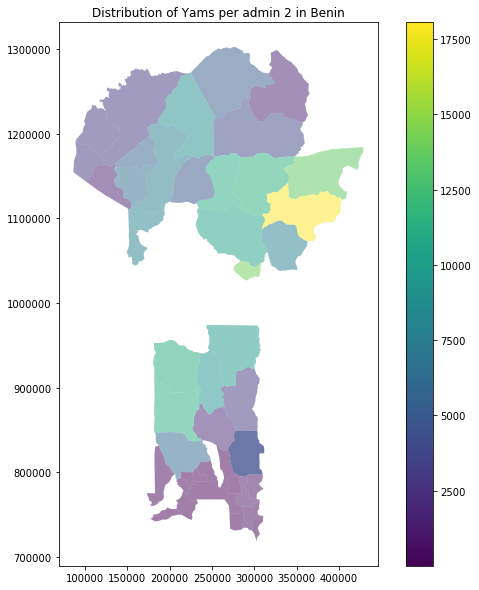

In [65]:
# Yams

# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all crops
admin_2_yams_gdf.sort_values('harv_area_ha', ascending=True).plot(
    ax=ax, column='harv_area_ha', legend=True, alpha=0.5)

# Make figure aspect ratio ensure that 10x10 km square appears square
ax.set_aspect('equal', 'box')
txt = ax.set_title('Distribution of {} per admin 2 in Benin'.format("Yams"))

# Save plot as figure 
plt.savefig('Yams_Harv_Area_2018.png', bbox_inches='tight')

### Step 6:  Exporting gdfs to shapefiles (shp)

In [66]:
admin_2_yams_gdf.to_file(os.path.join(path,"{c}.shp".format(c="Ben_yams_2018_admin2")))

# CROP 2: MAIZE

In [74]:
path = r"C:\Benin\agrodem_preprocessing\Downscaling\Output_Data\Crop_Maps_modified_FAO"
name_of_file= "Ben_maize_final.csv"
# Import csv as pandas dataframe
df_maize= pd.read_csv(path + "\\" + name_of_file)
df_maize.head()

,Unnamed: 0,AREA_NAME,YIELD_x,PRODUCTION_x,Harvest_Area_By_District,Unnamed: 0.1,COUNTRY_CODE,COUNTRY_NAME,AREA_CODE,ADMIN_LEVEL,...,ITEM_NAME,YEAR,AEREA_HARVESTED,YIELD_y,PRODUCTION_y,Admin_2_share,Area_Harv_2018,production_tonnes,ratio_harvested_area_by_district,final_prod_tonnes
0,0,Abomey,0.80299,538.0,1233.411270,238,BEN,Benin,BEN012001,2,...,Maize,2000,670.0,0.80299,538.0,0.001065,1233.411270,3031.0,1.0,3031.0
1,1,Abomey-Calavi,0.79299,17501.0,40617.889940,511,BEN,Benin,BEN003001,2,...,Maize,2000,22064.0,0.79299,17501.0,0.035082,40617.889940,12116.0,1.0,12116.0
2,2,Adja-ouere,1.31200,44122.0,61900.677540,9752,BEN,Benin,BEN011001,2,...,Maize,2000,33625.0,1.31200,44122.0,0.053464,61900.677540,25045.0,1.0,25045.0
3,3,Adjara,0.94700,1350.0,2623.300089,782,BEN,Benin,BEN010001,2,...,Maize,2000,1425.0,0.94700,1350.0,0.002266,2623.300089,1700.0,1.0,1700.0
4,4,Adjohoun,1.08200,6689.0,11376.838281,1060,BEN,Benin,BEN010002,2,...,Maize,2000,6180.0,1.08200,6689.0,0.009826,11376.838281,31376.0,1.0,31376.0


### Step 1: Renaming dfs

First, we need to rename the admin_2 column name in the previous dataframes in order to match with the "merging" column in the imported shapefile

In [75]:
df_maize.rename(columns={"AREA_NAME":"name_adm2"}, inplace=True)

### Step 2: Creating unique gdfs per crop

In [76]:
admin_2_maize_gdf = admin_2_gdf.merge(df_maize, on="name_adm2")

### Step 3: Cross-checking estimated

Calculating total area per district and cross-checking that projected harvested ara (as per method above) does not surpasses physical limits. Areas in ha.

In [77]:
admin_2_maize_gdf["tot_dist_area_ha"] = admin_2_maize_gdf['geometry'].to_crs({'init': 'epsg:3395'})\
                .map(lambda p: p.area / 10**4)
admin_2_maize_gdf["Test"] = admin_2_maize_gdf["tot_dist_area_ha"] > admin_2_maize_gdf["Area_Harv_2018"]
admin_2_maize_gdf["Test"].unique

C:\Users\oluchi\.conda\envs\agrodem_run\lib\site-packages\pyproj\crs\crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<bound method Series.unique of 0     True
1     True
2     True
3     True
4     True
      ... 
68    True
69    True
70    True
71    True
72    True
Name: Test, Length: 73, dtype: bool>

In [78]:
# Adding new column for the share of harvested area over the total area per district
admin_2_maize_gdf["harv_share_of_tot"] = admin_2_maize_gdf["Area_Harv_2018"] / admin_2_maize_gdf["tot_dist_area_ha"]

### Step 4: Cleaning the gdfs

In [79]:
admin_2_maize_gdf.columns

Index(['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'name_adm2', 'geometry', 'Unnamed: 0', 'YIELD_x', 'PRODUCTION_x',
       'Harvest_Area_By_District', 'Unnamed: 0.1', 'COUNTRY_CODE',
       'COUNTRY_NAME', 'AREA_CODE', 'ADMIN_LEVEL', 'ITEM_CODE', 'ITEM_NAME',
       'YEAR', 'AEREA_HARVESTED', 'YIELD_y', 'PRODUCTION_y', 'Admin_2_share',
       'Area_Harv_2018', 'production_tonnes',
       'ratio_harvested_area_by_district', 'final_prod_tonnes',
       'tot_dist_area_ha', 'Test', 'harv_share_of_tot'],
      dtype='object')

In [80]:
admin_2_maize_gdf.rename(columns={"COUNTRY_NAME":"country",
                                  "COUNTRY_CODE":"country_code",
                                  "name_adm2":"admin2",
                                  "ITEM_NAME":"crop",
                                  "AEREA_HARVESTED":"harea_area_ha",
                                  "YIELD":"yield",
                                  "PRODUCTION":"product_ha", 
                                  "Admin_2_share": "shareofsum",
                                  "Area_Harv_2018":"harv_area_ha",
                                  "tot_dist_area_ha":"district_area_ha",
                                  "harv_share_of_tot":"shareofdistrict"}, inplace=True)

admin_2_maize_gdf = admin_2_maize_gdf.drop(['NAME_0','ADMIN_LEVEL','ITEM_CODE','AREA_CODE','Test','YEAR','Unnamed: 0.1',
                                         'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2','NAME_2','VARNAME_2','NL_NAME_2', 'ENGTYPE_2','TYPE_2','CC_2', 'HASC_2',
                                          'production_tonnes','ratio_harvested_area_by_district'], axis=1)

In [81]:
admin_2_maize_gdf.describe()

,Unnamed: 0,YIELD_x,PRODUCTION_x,Harvest_Area_By_District,harea_area_ha,YIELD_y,PRODUCTION_y,shareofsum,harv_area_ha,final_prod_tonnes,district_area_ha,shareofdistrict
count,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,73.000000,5.800000e+01,73.000000,73.000000
mean,35.684932,1.130696,10856.013699,17193.087348,9339.438356,1.130696,10856.013699,0.014850,17193.087348,5.714871e+04,141398.060777,0.307206
std,21.010498,0.426889,13836.348862,19783.801501,10746.737385,0.426889,13836.348862,0.017087,19783.801501,2.032112e+05,155551.585937,0.390554
min,0.000000,0.333000,1.000000,5.522737,3.000000,0.333000,1.000000,0.000005,5.522737,1.010000e+02,4180.298631,0.001321
25%,18.000000,0.861000,2944.000000,5145.349999,2795.000000,0.861000,2944.000000,0.004444,5145.349999,6.215250e+03,28468.421359,0.049414
50%,36.000000,1.027000,6277.000000,11698.997941,6355.000000,1.027000,6277.000000,0.010104,11698.997941,1.203700e+04,53327.394001,0.101945
75%,53.000000,1.301000,12758.000000,20936.696079,11373.000000,1.301000,12758.000000,0.018083,20936.696079,2.929375e+04,218555.153335,0.395181
max,72.000000,3.088000,69059.000000,97734.036300,53090.000000,3.088000,69059.000000,0.084413,97734.036300,1.118880e+06,618456.421733,1.844894


### Step 5: Quick visualization of results

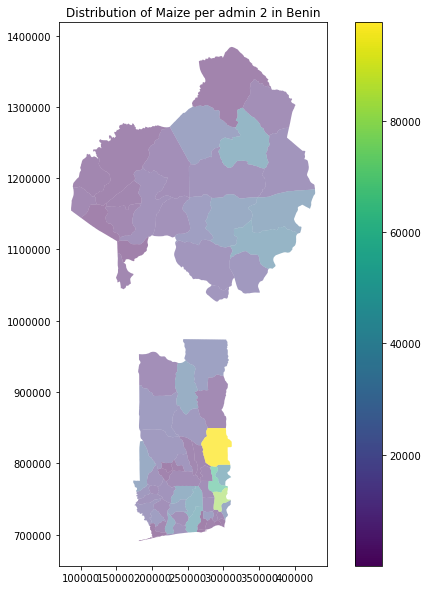

In [82]:
# Maize

# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all crops
admin_2_maize_gdf.sort_values('harv_area_ha', ascending=True).plot(
    ax=ax, column='harv_area_ha', legend=True, alpha=0.5)

# Make figure aspect ratio ensure that 10x10 km square appears square
ax.set_aspect('equal', 'box')
txt = ax.set_title('Distribution of {} per admin 2 in Benin'.format("Maize"))

# Save plot as figure 
plt.savefig('Maize_Harv_Area_2018.png', bbox_inches='tight')

### Step 6:  Exporting gdfs to shapefiles (shp)

In [83]:
admin_2_maize_gdf.to_file(os.path.join(path,"{c}.shp".format(c="Ben_maize_2018_admin2")))

# CROP 3: CASSAVA

In [84]:
path = r"C:\Benin\agrodem_preprocessing\Downscaling\Output_Data\Crop_Maps_modified_FAO"
name_of_file= "Ben_cassava_final.csv"
# Import csv as pandas dataframe
df_cassava= pd.read_csv(path + "\\" + name_of_file)
df_cassava.head()

,Unnamed: 0,AREA_NAME,Harvest_Area_By_District,Unnamed: 0.1,COUNTRY_CODE,COUNTRY_NAME,AREA_CODE,ADMIN_LEVEL,ITEM_CODE,ITEM_NAME,YEAR,AEREA_HARVESTED,YIELD,PRODUCTION,Admin_2_share,Area_Harv_2018,production_tonnes,ratio_harvested_area_by_district,final_prod_tonnes
0,0,Abomey,704.836036,31,BEN,Benin,BEN012001,2,125,Cassava,2000,509.0,7.000,3563.0,0.002510,704.836036,15857.0,1.0,15857.0
1,1,Abomey-Calavi,11864.509143,342,BEN,Benin,BEN003001,2,125,Cassava,2000,8568.0,6.858,58761.0,0.042251,11864.509143,120957.0,1.0,120957.0
2,2,Adja-ouere,11271.837584,9573,BEN,Benin,BEN011001,2,125,Cassava,2000,8140.0,15.082,122767.0,0.040140,11271.837584,118280.0,1.0,118280.0
3,3,Adjara,552.513906,613,BEN,Benin,BEN010001,2,125,Cassava,2000,399.0,7.293,2910.0,0.001968,552.513906,3771.0,1.0,3771.0
4,4,Adjohoun,2367.916741,884,BEN,Benin,BEN010002,2,125,Cassava,2000,1710.0,10.229,17491.0,0.008432,2367.916741,54582.0,1.0,54582.0


### Step 1: Renaming dfs

First, we need to rename the admin_2 column name in the previous dataframes in order to match with the "merging" column in the imported shapefile

In [86]:
df_cassava.rename(columns={"AREA_NAME":"name_adm2"}, inplace=True)

### Step 2: Creating unique gdfs per crop

In [87]:
admin_2_cassava_gdf = admin_2_gdf.merge(df_cassava, on="name_adm2")

### Step 3: Cross-checking estimated

Calculating total area per district and cross-checking that projected harvested ara (as per method above) does not surpasses physical limits. Areas in ha.

In [88]:
admin_2_cassava_gdf["tot_dist_area_ha"] = admin_2_cassava_gdf['geometry'].to_crs({'init': 'epsg:3395'})\
                .map(lambda p: p.area / 10**4)
admin_2_cassava_gdf["Test"] = admin_2_cassava_gdf["tot_dist_area_ha"] > admin_2_cassava_gdf["Area_Harv_2018"]
admin_2_cassava_gdf["Test"].unique

C:\Users\oluchi\.conda\envs\agrodem_run\lib\site-packages\pyproj\crs\crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<bound method Series.unique of 0     True
1     True
2     True
3     True
4     True
      ... 
67    True
68    True
69    True
70    True
71    True
Name: Test, Length: 72, dtype: bool>

In [89]:
# Adding new column for the share of harvested area over the total area per district
admin_2_cassava_gdf["harv_share_of_tot"] = admin_2_cassava_gdf["Area_Harv_2018"] / admin_2_cassava_gdf["tot_dist_area_ha"]

### Step 4: Cleaning the gdfs

In [90]:
admin_2_cassava_gdf.columns

Index(['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'name_adm2', 'geometry', 'Unnamed: 0', 'Harvest_Area_By_District',
       'Unnamed: 0.1', 'COUNTRY_CODE', 'COUNTRY_NAME', 'AREA_CODE',
       'ADMIN_LEVEL', 'ITEM_CODE', 'ITEM_NAME', 'YEAR', 'AEREA_HARVESTED',
       'YIELD', 'PRODUCTION', 'Admin_2_share', 'Area_Harv_2018',
       'production_tonnes', 'ratio_harvested_area_by_district',
       'final_prod_tonnes', 'tot_dist_area_ha', 'Test', 'harv_share_of_tot'],
      dtype='object')

In [91]:
admin_2_cassava_gdf.rename(columns={"COUNTRY_NAME":"country",
                                  "COUNTRY_CODE":"country_code",
                                  "name_adm2":"admin2",
                                  "ITEM_NAME":"crop",
                                  "AEREA_HARVESTED":"harea_area_ha",
                                  "YIELD":"yield",
                                  "PRODUCTION":"product_ha", 
                                  "Admin_2_share": "shareofsum",
                                  "Area_Harv_2018":"harv_area_ha",
                                  "tot_dist_area_ha":"district_area_ha",
                                  "harv_share_of_tot":"shareofdistrict"}, inplace=True)

admin_2_cassava_gdf = admin_2_cassava_gdf.drop(['NAME_0','ADMIN_LEVEL','ITEM_CODE','AREA_CODE','Test','YEAR','Unnamed: 0.1',
                                         'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2','NAME_2','VARNAME_2','NL_NAME_2', 'ENGTYPE_2','TYPE_2','CC_2', 'HASC_2',
                                          'production_tonnes','ratio_harvested_area_by_district'], axis=1)

In [92]:
admin_2_cassava_gdf.describe()

,Unnamed: 0,Harvest_Area_By_District,harea_area_ha,yield,product_ha,shareofsum,harv_area_ha,final_prod_tonnes,district_area_ha,shareofdistrict
count,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,72.000000,57.000000,72.000000,72.000000
mean,35.180556,4134.545722,2985.777778,10.340625,32645.736111,0.014724,4134.545722,61298.929825,142476.107380,0.090051
std,20.708117,5800.517211,4188.865369,4.836810,49279.203190,0.020656,5800.517211,134411.195516,156368.329269,0.152650
min,0.000000,2.769493,2.000000,4.032000,10.000000,0.000010,2.769493,90.000000,4180.298631,0.000215
25%,17.750000,707.605529,511.000000,7.000000,3550.250000,0.002520,707.605529,7042.000000,28024.947285,0.008709
50%,35.500000,2010.652110,1452.000000,8.983000,16530.000000,0.007160,2010.652110,20246.000000,53080.309587,0.035102
75%,52.250000,4486.232901,3239.750000,12.942250,38713.000000,0.015976,4486.232901,54582.000000,218741.308090,0.084001
max,71.000000,32619.091662,23556.000000,27.763000,248876.000000,0.116161,32619.091662,705797.000000,618456.421733,0.733379


### Step 5: Quick visualization of results

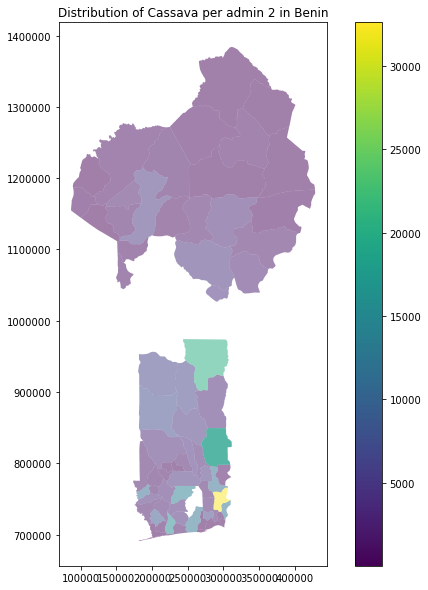

In [93]:
# Cassava

# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all crops
admin_2_cassava_gdf.sort_values('harv_area_ha', ascending=True).plot(
    ax=ax, column='harv_area_ha', legend=True, alpha=0.5)

# Make figure aspect ratio ensure that 10x10 km square appears square
ax.set_aspect('equal', 'box')
txt = ax.set_title('Distribution of {} per admin 2 in Benin'.format("Cassava"))

# Save plot as figure 
plt.savefig('Cassava_Harv_Area_2018.png', bbox_inches='tight')

### Step 6:  Exporting gdfs to shapefiles (shp)

In [94]:
admin_2_cassava_gdf.to_file(os.path.join(path,"{c}.shp".format(c="Ben_cassava_2018_admin2")))

# CROP 4: COTTON

In [95]:
path = r"C:\Benin\agrodem_preprocessing\Downscaling\Output_Data\Crop_Maps_modified_FAO"
name_of_file= "Ben_cotton_final.csv"
# Import csv as pandas dataframe
df_cotton= pd.read_csv(path + "\\" + name_of_file)
df_cotton.head()

,Unnamed: 0,AREA_NAME,Harvest_Area_By_District,Unnamed: 0.1,COUNTRY_CODE,COUNTRY_NAME,AREA_CODE,ADMIN_LEVEL,ITEM_CODE,ITEM_NAME,YEAR,AEREA_HARVESTED,Admin_2_share,Area_Harv_2018,production_tonnes,ratio_harvested_area_by_district,final_prod_tonnes
0,0,Abomey,1512.829075,0,BEN,Benin,BEN012001,2,328,Seed Cotton,1999,959,0.002521,1512.829075,3031.0,1.0,3031.0
1,1,Adja-ouere,1260.427978,19,BEN,Benin,BEN011001,2,328,Seed Cotton,1999,799,0.002101,1260.427978,25045.0,1.0,25045.0
2,2,Agbangnizoun,1269.893019,1,BEN,Benin,BEN012002,2,328,Seed Cotton,1999,805,0.002116,1269.893019,5809.0,1.0,5809.0
3,3,Aplahoue,21037.631430,2,BEN,Benin,BEN006001,2,328,Seed Cotton,1999,13336,0.035063,21037.631430,NaN,1.0,NaN
4,4,Athieme,118.313014,3,BEN,Benin,BEN009001,2,328,Seed Cotton,1999,75,0.000197,118.313014,5708.0,1.0,5708.0


### Step 1: Renaming dfs

First, we need to rename the admin_2 column name in the previous dataframes in order to match with the "merging" column in the imported shapefile

In [96]:
df_cotton.rename(columns={"AREA_NAME":"name_adm2"}, inplace=True)

### Step 2: Creating unique gdfs per crop

In [97]:
admin_2_cotton_gdf = admin_2_gdf.merge(df_cotton, on="name_adm2")

### Step 3: Cross-checking estimated

Calculating total area per district and cross-checking that projected harvested ara (as per method above) does not surpasses physical limits. Areas in ha.

In [98]:
admin_2_cotton_gdf["tot_dist_area_ha"] = admin_2_cotton_gdf['geometry'].to_crs({'init': 'epsg:3395'})\
                .map(lambda p: p.area / 10**4)
admin_2_cotton_gdf["Test"] = admin_2_cotton_gdf["tot_dist_area_ha"] > admin_2_cotton_gdf["Area_Harv_2018"]
admin_2_cotton_gdf["Test"].unique

C:\Users\oluchi\.conda\envs\agrodem_run\lib\site-packages\pyproj\crs\crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


<bound method Series.unique of 0     True
1     True
2     True
3     True
4     True
5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
14    True
15    True
16    True
17    True
18    True
19    True
20    True
21    True
22    True
23    True
24    True
25    True
26    True
27    True
28    True
29    True
30    True
31    True
32    True
33    True
34    True
35    True
36    True
37    True
38    True
39    True
40    True
41    True
42    True
43    True
44    True
45    True
46    True
47    True
48    True
49    True
50    True
Name: Test, dtype: bool>

In [99]:
# Adding new column for the share of harvested area over the total area per district
admin_2_cotton_gdf["harv_share_of_tot"] = admin_2_cotton_gdf["Area_Harv_2018"] / admin_2_cotton_gdf["tot_dist_area_ha"]

### Step 4: Cleaning the gdfs

In [100]:
admin_2_cotton_gdf.columns

Index(['GID_0', 'NAME_0', 'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2', 'NAME_2',
       'VARNAME_2', 'NL_NAME_2', 'TYPE_2', 'ENGTYPE_2', 'CC_2', 'HASC_2',
       'name_adm2', 'geometry', 'Unnamed: 0', 'Harvest_Area_By_District',
       'Unnamed: 0.1', 'COUNTRY_CODE', 'COUNTRY_NAME', 'AREA_CODE',
       'ADMIN_LEVEL', 'ITEM_CODE', 'ITEM_NAME', 'YEAR', 'AEREA_HARVESTED',
       'Admin_2_share', 'Area_Harv_2018', 'production_tonnes',
       'ratio_harvested_area_by_district', 'final_prod_tonnes',
       'tot_dist_area_ha', 'Test', 'harv_share_of_tot'],
      dtype='object')

In [101]:
admin_2_cotton_gdf.rename(columns={"COUNTRY_NAME":"country",
                                  "COUNTRY_CODE":"country_code",
                                  "name_adm2":"admin2",
                                  "ITEM_NAME":"crop",
                                  "AEREA_HARVESTED":"harea_area_ha",
                                  "YIELD":"yield",
                                  "PRODUCTION":"product_ha", 
                                  "Admin_2_share": "shareofsum",
                                  "Area_Harv_2018":"harv_area_ha",
                                  "tot_dist_area_ha":"district_area_ha",
                                  "harv_share_of_tot":"shareofdistrict"}, inplace=True)

admin_2_cotton_gdf = admin_2_cotton_gdf.drop(['NAME_0','ADMIN_LEVEL','ITEM_CODE','AREA_CODE','Test','YEAR','Unnamed: 0.1',
                                         'GID_1', 'NAME_1', 'NL_NAME_1', 'GID_2','NAME_2','VARNAME_2','NL_NAME_2', 'ENGTYPE_2','TYPE_2','CC_2', 'HASC_2',
                                          'production_tonnes','ratio_harvested_area_by_district'], axis=1)

In [102]:
admin_2_cotton_gdf.describe()

,Unnamed: 0,Harvest_Area_By_District,harea_area_ha,shareofsum,harv_area_ha,final_prod_tonnes,district_area_ha,shareofdistrict
count,51.000000,51.000000,51.000000,51.000000,51.000000,3.700000e+01,51.000000,51.000000
mean,24.490196,11986.948760,7598.666667,0.019978,11986.948760,8.336124e+04,191185.752428,0.088906
std,14.431040,11508.652602,7295.469152,0.019181,11508.652602,2.517430e+05,162289.771740,0.105166
min,0.000000,118.313014,75.000000,0.000197,118.313014,3.031000e+03,13562.801804,0.001537
25%,12.500000,2054.702680,1302.500000,0.003425,2054.702680,9.003000e+03,47253.345104,0.032892
50%,24.000000,9778.964998,6199.000000,0.016298,9778.964998,1.990900e+04,174998.211276,0.064769
75%,36.500000,18598.805830,11790.000000,0.030998,18598.805830,3.705600e+04,324453.425201,0.091586
max,49.000000,45438.507470,28804.000000,0.075731,45438.507470,1.118880e+06,618456.421733,0.546993


### Step 5: Quick visualization of results

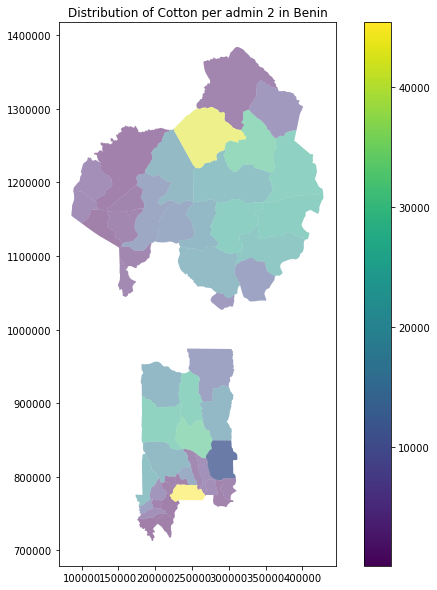

In [103]:
# Cotton

# Create the axis first
fig, ax = plt.subplots(figsize=(10, 10))

# Plot all crops
admin_2_cotton_gdf.sort_values('harv_area_ha', ascending=True).plot(
    ax=ax, column='harv_area_ha', legend=True, alpha=0.5)

# Make figure aspect ratio ensure that 10x10 km square appears square
ax.set_aspect('equal', 'box')
txt = ax.set_title('Distribution of {} per admin 2 in Benin'.format("Cotton"))

# Save plot as figure 
plt.savefig('Cotton_Harv_Area_2018.png', bbox_inches='tight')

### Step 6:  Exporting gdfs to shapefiles (shp)

In [104]:
admin_2_cotton_gdf.to_file(os.path.join(path,"{c}.shp".format(c="Ben_cotton_2018_admin2")))